# Load modules

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV

import shap 

%load_ext tensorboard

# Load data

In [2]:
data = np.load(os.path.join('data', 'dataset_smile_challenge.npy'), allow_pickle = True).item()

#training dataset 
train = data['train']
deep_features_train = train['deep_features'] # for deep features {'ECG_features_C', 'ECG_features_T'}.
handcrafted_features_train = train['hand_crafted_features'] # for hand-crafted features {'ECG_features', 'GSR_features'}.

#test dataset
test = data['test']
deep_features_test = test['deep_features'] # for deep features {'ECG_features_C', 'ECG_features_T'}.
handcrafted_features_test = test['hand_crafted_features'] # for hand-crafted features {'ECG_features', 'GSR_features'}.

# extracting labels and converting labels >= 1 to just 1.
y_train = train['labels']
th = 1
y_train[y_train<th] = 0
y_train[y_train>0] = 1

idx = np.random.permutation(len(deep_features_train['ECG_features_C']))
deep_features_train['ECG_features_C'] = deep_features_train['ECG_features_C'][idx]
deep_features_train['ECG_features_T'] = deep_features_train['ECG_features_T'][idx]
deep_features_train['masking'] = deep_features_train['masking'][idx]
handcrafted_features_train['ECG_features'] = handcrafted_features_train['ECG_features'][idx]
handcrafted_features_train['ECG_masking'] = handcrafted_features_train['ECG_masking'][idx]
handcrafted_features_train['GSR_features'] = handcrafted_features_train['GSR_features'][idx]
handcrafted_features_train['GSR_masking'] = handcrafted_features_train['GSR_masking'][idx]
y_train = y_train[idx]

# Analyze dataset

In [3]:
#Evaluate shapes
print('Shape of deep_features[ECG_features_C]: ' + str(deep_features_train['ECG_features_C'].shape))
print('Shape of deep_features[ECG_features_T]: ' + str(deep_features_train['ECG_features_T'].shape))

print('Shape of handcrafted_features[ECG_features]: ' + str(handcrafted_features_train['ECG_features'].shape))
print('Shape of handcrafted_features[GSR_features]: ' + str(handcrafted_features_train['GSR_features'].shape))

Shape of deep_features[ECG_features_C]: (2070, 60, 256)
Shape of deep_features[ECG_features_T]: (2070, 60, 64)
Shape of handcrafted_features[ECG_features]: (2070, 60, 8)
Shape of handcrafted_features[GSR_features]: (2070, 60, 12)


# Preprocessing: masking

In [4]:
#Putting to 0 nans in handcrafted_features['ECG_features']
flag_df_egc = np.argwhere(np.isnan(handcrafted_features_train['ECG_features']))
for f in flag_df_egc:
    handcrafted_features_train['ECG_features'][f[0],f[1],f[2]] = 0
flag_df_egc = np.argwhere(np.isnan(handcrafted_features_test['ECG_features']))
for f in flag_df_egc:
    handcrafted_features_test['ECG_features'][f[0],f[1],f[2]] = 0

#Shape understanding 101:
#   We have X features for each timestep.
#   We have 60 timesteps.
#   We have 2070 samples.
#So, each time we are feeding the LSTM with X features, 1 for each timestep, 60 times 

In [5]:
flag_df_egc

array([[156,  34,   0],
       [156,  34,   7],
       [156,  35,   0],
       ...,
       [837,   5,   7],
       [837,  19,   5],
       [837,  20,   5]])

In [6]:
handcrafted_features_train['ECG_features'][436,30,:]

array([0.03352751, 0.01502979, 0.01175338, 0.04010911, 0.24849451,
       0.0491753 , 0.07798611, 0.03721914])

In [7]:
np.argwhere(np.isnan(handcrafted_features_train['GSR_features']))

array([], shape=(0, 3), dtype=int64)

<AxesSubplot:>

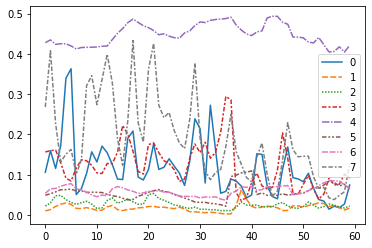

In [8]:
#Visualize a data sample
sns.lineplot(data=handcrafted_features_train['ECG_features'][0])

<AxesSubplot:>

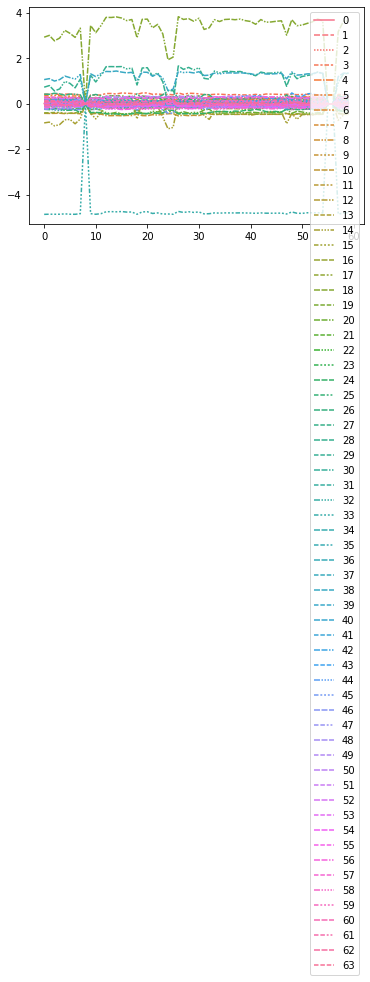

In [9]:
#Visualize a data sample
sns.lineplot(data=deep_features_train['ECG_features_T'][4])
#sns.lineplot(data=deep_features_train['masking'][0])


<AxesSubplot:>

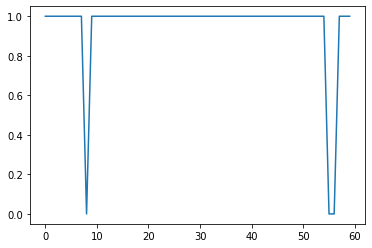

In [10]:
sns.lineplot(data=deep_features_train['masking'][4])

In [11]:
print('Prevalence of CLASS = 0: ' + str(100*np.sum(y_train)/y_train.shape[0]) + '%')
print('Prevalence of CLASS = 1: ' + str(100*(y_train.shape[0]-np.sum(y_train))/y_train.shape[0]) + '%')

Prevalence of CLASS = 0: 52.7536231884058%
Prevalence of CLASS = 1: 47.2463768115942%


# Model building

In [38]:
inp1 = tf.keras.layers.Input(shape=(deep_features_train['ECG_features_C'].shape[1], deep_features_train['ECG_features_C'].shape[2]))
inp2 = tf.keras.layers.Input(shape=(deep_features_train['ECG_features_T'].shape[1], deep_features_train['ECG_features_T'].shape[2]))
inp3 = tf.keras.layers.Input(shape=(handcrafted_features_train['ECG_features'].shape[1], handcrafted_features_train['ECG_features'].shape[2]))
inp4 = tf.keras.layers.Input(shape=(handcrafted_features_train['GSR_features'].shape[1], handcrafted_features_train['GSR_features'].shape[2]))

n_units = 32
n_batch = 64 
recurrent_dropout = 0.5
dropout = 0.1

two_layers = False

#x = tf.keras.layers.Masking(mask_value=0.)(inp1)
#x = tf.keras.layers.GRU(n_units,recurrent_dropout=recurrent_dropout)(x)
#x = tf.keras.layers.Dropout(dropout)(x)
#x = tf.keras.layers.Dense(1)(x)

x = tf.keras.layers.Masking(mask_value=0.)(inp1)
x = tf.keras.layers.GRU(n_units, dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=two_layers)(x)
if two_layers:
    x = tf.keras.layers.GRU(int(n_units/2), dropout = dropout, recurrent_dropout=recurrent_dropout)(x)

#y = tf.keras.layers.Masking(mask_value=0.)(inp2)
#y = tf.keras.layers.LSTM(n_units,recurrent_dropout=recurrent_dropout)(y)
#y = tf.keras.layers.Dropout(dropout)(y)
#y = tf.keras.layers.Dense(1)(y)

y = tf.keras.layers.Masking(mask_value=0.)(inp2)
y = tf.keras.layers.GRU(n_units, dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=two_layers)(y)
if two_layers:
    y = tf.keras.layers.GRU(int(n_units/2), dropout = dropout, recurrent_dropout=recurrent_dropout)(y)

#z = tf.keras.layers.Masking(mask_value=0.)(inp3)
#z = tf.keras.layers.LSTM(n_units,recurrent_dropout=recurrent_dropout)(inp3)
#z = tf.keras.layers.Dropout(dropout)(z)
#z = tf.keras.layers.Dense(1)(z)

z = tf.keras.layers.Masking(mask_value=0.)(inp3)
z = tf.keras.layers.GRU(n_units, dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=two_layers)(z)
if two_layers:
    z = tf.keras.layers.GRU(int(n_units/2), dropout = dropout, recurrent_dropout=recurrent_dropout)(z)

w = tf.keras.layers.Masking(mask_value=0.)(inp4)
w = tf.keras.layers.GRU(n_units, dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=two_layers)(inp4)
if two_layers:
    w = tf.keras.layers.GRU(int(n_units/2), dropout = dropout, recurrent_dropout=recurrent_dropout)(w)
#w = tf.keras.layers.Dense(1)(w)

c = tf.keras.layers.Concatenate()([
    x,
    y,
    z, 
    w
])

out =  tf.keras.layers.Dense(1, activation='sigmoid')(c)

model = tf.keras.models.Model(inputs=[
        inp1,
        inp2,
        inp3,
        inp4
        ],
        outputs=out)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print(model.summary())

model.fit(x=[
            deep_features_train['ECG_features_C'],
            deep_features_train['ECG_features_T'],
            handcrafted_features_train['ECG_features'],
            handcrafted_features_train['GSR_features']
            ], 
          y=y_train, 
          epochs=50,
          validation_split=0.2,
          callbacks=[tensorboard_callback],
          batch_size = n_batch)


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 60, 256)]    0           []                               
                                                                                                  
 input_58 (InputLayer)          [(None, 60, 64)]     0           []                               
                                                                                                  
 input_59 (InputLayer)          [(None, 60, 8)]      0           []                               
                                                                                                  
 masking_41 (Masking)           (None, 60, 256)      0           ['input_57[0][0]']               
                                                                                           

26/26 [==============================] - 2s 90ms/step - loss: 0.5560 - accuracy: 0.7228 - val_loss: 0.6370 - val_accuracy: 0.6401
Epoch 35/50
26/26 [==============================] - 2s 72ms/step - loss: 0.5537 - accuracy: 0.7168 - val_loss: 0.6149 - val_accuracy: 0.6594
Epoch 36/50
26/26 [==============================] - 2s 76ms/step - loss: 0.5589 - accuracy: 0.7083 - val_loss: 0.6070 - val_accuracy: 0.6787
Epoch 37/50
26/26 [==============================] - 2s 76ms/step - loss: 0.5555 - accuracy: 0.7222 - val_loss: 0.6150 - val_accuracy: 0.6618
Epoch 38/50
26/26 [==============================] - 2s 82ms/step - loss: 0.5545 - accuracy: 0.7132 - val_loss: 0.6073 - val_accuracy: 0.6787
Epoch 39/50
26/26 [==============================] - 2s 76ms/step - loss: 0.5483 - accuracy: 0.7192 - val_loss: 0.6034 - val_accuracy: 0.6739
Epoch 40/50
26/26 [==============================] - 2s 75ms/step - loss: 0.5419 - accuracy: 0.7240 - val_loss: 0.6153 - val_accuracy: 0.6691
Epoch 41/50
26/26 

In [39]:
%tensorboard --logdir logs/fit

In [40]:

explainer = shap.DeepExplainer(model, [
            deep_features_train['ECG_features_C'],
            deep_features_train['ECG_features_T'],
            handcrafted_features_train['ECG_features'],
            handcrafted_features_train['GSR_features']
            ])
shap_values = explainer.shap_values(handcrafted_features_test['GSR_features'])


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


AssertionError: Expected a list of model inputs!

In [41]:
model = tf.keras.models.Model(inputs=[
        inp1,
        inp2,
        inp3,
        inp4
        ],
        outputs=out)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print(model.summary())

model.fit(x=[
            deep_features_train['ECG_features_C'],
            deep_features_train['ECG_features_T'],
            handcrafted_features_train['ECG_features'],
            handcrafted_features_train['GSR_features']
            ], 
          y=y_train, 
          epochs=50,
          callbacks=[tensorboard_callback],
          batch_size = n_batch)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 60, 256)]    0           []                               
                                                                                                  
 input_58 (InputLayer)          [(None, 60, 64)]     0           []                               
                                                                                                  
 input_59 (InputLayer)          [(None, 60, 8)]      0           []                               
                                                                                                  
 masking_41 (Masking)           (None, 60, 256)      0           ['input_57[0][0]']               
                                                                                           

33/33 [==============================] - 3s 82ms/step - loss: 0.4971 - accuracy: 0.7575
Epoch 49/50
33/33 [==============================] - 3s 79ms/step - loss: 0.4917 - accuracy: 0.7599
Epoch 50/50
33/33 [==============================] - 3s 81ms/step - loss: 0.5014 - accuracy: 0.7599


# Make and save predictions

In [47]:
y_hat_test = model.predict([
            deep_features_test['ECG_features_C'],
            deep_features_test['ECG_features_T'],
            handcrafted_features_test['ECG_features'],
            handcrafted_features_test['GSR_features']
            ])
print(y_hat_test)
th = 0.5
#y_hat_test[np.argwhere(np.isnan(y_hat_test))]= 0
y_hat_test[y_hat_test >= th] = 1
y_hat_test[y_hat_test < th] = 0
np.savetxt(os.path.join('submission', 'answer.txt'),y_hat_test.astype(int),fmt='%1d')

31/31 [==============================] - 1s 18ms/step
[[0.83282954]
 [0.9071522 ]
 [0.82926744]
 [0.7219728 ]
 [0.8353695 ]
 [0.78753936]
 [0.87795025]
 [0.6225577 ]
 [0.8807009 ]
 [0.8392026 ]
 [0.81002384]
 [0.66314495]
 [0.72830176]
 [0.7584778 ]
 [0.6439069 ]
 [0.9001313 ]
 [0.8364015 ]
 [0.8898527 ]
 [0.7983132 ]
 [0.7758212 ]
 [0.77420306]
 [0.8605481 ]
 [0.9234942 ]
 [0.9221051 ]
 [0.5240342 ]
 [0.49957296]
 [0.8215815 ]
 [0.8618228 ]
 [0.75517255]
 [0.8658202 ]
 [0.73686576]
 [0.7415127 ]
 [0.79233   ]
 [0.78418994]
 [0.9055065 ]
 [0.88557184]
 [0.847536  ]
 [0.82707524]
 [0.802232  ]
 [0.93635863]
 [0.79902655]
 [0.89981055]
 [0.934973  ]
 [0.91819614]
 [0.88505495]
 [0.9176502 ]
 [0.8895521 ]
 [0.85697377]
 [0.9343346 ]
 [0.8708681 ]
 [0.82220185]
 [0.8425602 ]
 [0.8810805 ]
 [0.86267656]
 [0.83001494]
 [0.8944683 ]
 [0.8277423 ]
 [0.86100537]
 [0.77519226]
 [0.7372723 ]
 [0.8948345 ]
 [0.44225442]
 [0.813053  ]
 [0.8923423 ]
 [0.73131067]
 [0.761462  ]
 [0.8143985 ]
 [0.8672

 [0.5436445 ]]


In [45]:
np.sum(y_hat_test)

369.0